In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os
import zipfile

In [2]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Saving kaggle.json to kaggle.json
 98% 116M/119M [00:06<00:00, 23.8MB/s]
100% 119M/119M [00:06<00:00, 19.4MB/s]


In [3]:
with zipfile.ZipFile("chest-ctscan-images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/chest-ctscan-images")

In [4]:
import numpy as np
import cv2
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def load_dataset(dataset_folder_path):
    data = []
    labels = []
    label_to_int = {}
    int_label = 0
    for folder_name in os.listdir(dataset_folder_path):
        if folder_name not in label_to_int:
            label_to_int[folder_name] = int_label
            int_label += 1
        folder_path = os.path.join(dataset_folder_path, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            data.append(image)
            labels.append(folder_name)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels, label_to_int

test_dataset_path = "/content/chest-ctscan-images/Data/test/"
test_data, test_labels, label_to_int = load_dataset(test_dataset_path)


train_dataset_path = "/content/chest-ctscan-images/Data/train/"
train_data, train_labels, label_to_int = load_dataset(train_dataset_path)


valid_dataset_path = "/content/chest-ctscan-images/Data/valid/"
valid_data, valid_labels, label_to_int = load_dataset(valid_dataset_path)


train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)
valid_data, valid_labels = shuffle(valid_data, valid_labels, random_state=42)


train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
valid_data = valid_data.astype('float32') / 255.0


train_labels_mapped = np.array([label_to_int[label] for label in train_labels])

train_labels_mapped = np.array([label_to_int[label] for label in train_labels])


test_labels_mapped = []
for label in test_labels:
    if label in label_to_int:
        test_labels_mapped.append(label_to_int[label])
    else:
        pass

test_labels_mapped = np.array(test_labels_mapped)

valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])
valid_labels_mapped = np.array([label_to_int[label] for label in valid_labels])

num_classes = len(label_to_int)
train_labels = tf.keras.utils.to_categorical(train_labels_mapped, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels_mapped, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels_mapped, num_classes)


In [5]:
from sklearn.model_selection import train_test_split
new_train_data, new_test_data, new_train_labels, new_test_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)
combined_data = np.concatenate((new_train_data, new_test_data), axis=0)
combined_labels = np.concatenate((new_train_labels, new_test_labels), axis=0)

combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=42)

train_data, test_data, train_labels, test_labels = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42
)

print("Final training dataset size:", len(train_data))
print("Final test dataset size:", len(test_data))

Final training dataset size: 490
Final test dataset size: 123


In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model

def inception_module(x, filters):
    conv1x1_1 = Conv2D(filters[0], (1, 1), activation='relu', padding='same')(x)

    conv1x1_2 = Conv2D(filters[1], (1, 1), activation='relu', padding='same')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), activation='relu', padding='same')(conv1x1_2)

    conv1x1_3 = Conv2D(filters[3], (1, 1), activation='relu', padding='same')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), activation='relu', padding='same')(conv1x1_3)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), activation='relu', padding='same')(maxpool)

    inception_block = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)

    return inception_block

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)


x = inception_module(x, filters=[64, 128, 128, 64, 192, 32])
x = inception_module(x, filters=[128, 128, 192, 96, 208, 16])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)


x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_module(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_module(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_module(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)


x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_module(x, filters=[384, 192, 384, 48, 128, 128])
x = AveragePooling2D((7, 7), strides=(1, 1), padding='valid')(x)


x = Flatten()(x)


x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

googlenet_model = Model(inputs=input_layer, outputs=output_layer)


googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

googlenet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [7]:
print(len(train_data), len(train_labels))
print(len(test_data), len(test_labels))
print(len(valid_data), len(valid_labels))

490 490
123 123
72 72


In [8]:

batch_size = 32
epochs = 10
history = googlenet_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

Epoch 1/10
16/16 [==============================] - 52s 462ms/step - loss: 2.1499 - accuracy: 0.3204 - val_loss: 1.3817 - val_accuracy: 0.3008
Epoch 2/10
16/16 [==============================] - 2s 128ms/step - loss: 1.3752 - accuracy: 0.3224 - val_loss: 1.3565 - val_accuracy: 0.3008
Epoch 3/10
16/16 [==============================] - 2s 138ms/step - loss: 1.3523 - accuracy: 0.3408 - val_loss: 1.3729 - val_accuracy: 0.3008
Epoch 4/10
16/16 [==============================] - 2s 130ms/step - loss: 1.3741 - accuracy: 0.3224 - val_loss: 1.2937 - val_accuracy: 0.5285
Epoch 5/10
16/16 [==============================] - 2s 138ms/step - loss: 1.3888 - accuracy: 0.3429 - val_loss: 1.3716 - val_accuracy: 0.3008
Epoch 6/10
16/16 [==============================] - 2s 129ms/step - loss: 1.3706 - accuracy: 0.3224 - val_loss: 1.3698 - val_accuracy: 0.3008
Epoch 7/10
16/16 [==============================] - 2s 128ms/step - loss: 1.3704 - accuracy: 0.3224 - val_loss: 1.3690 - val_accuracy: 0.3008
Epoch

In [9]:
test_loss, test_accuracy = googlenet_model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 0s 55ms/step - loss: 1.3725 - accuracy: 0.3008
Test Loss: 1.3724640607833862
Test Accuracy: 0.3008130192756653


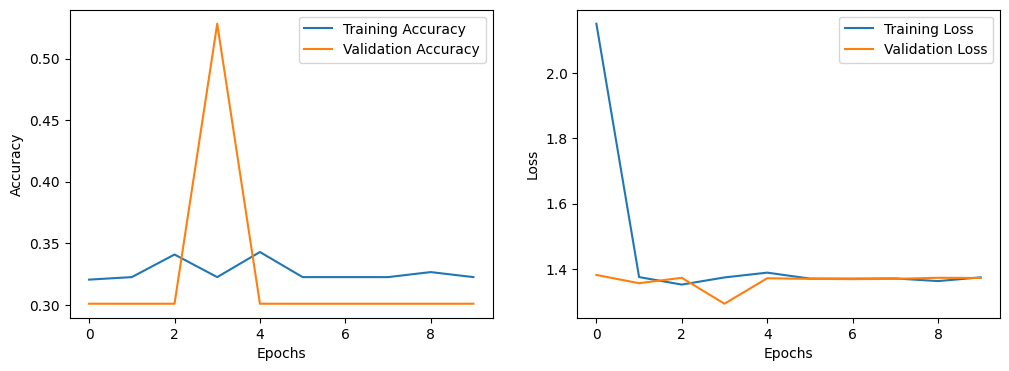

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

4/4 [==============================] - 1s 40ms/step


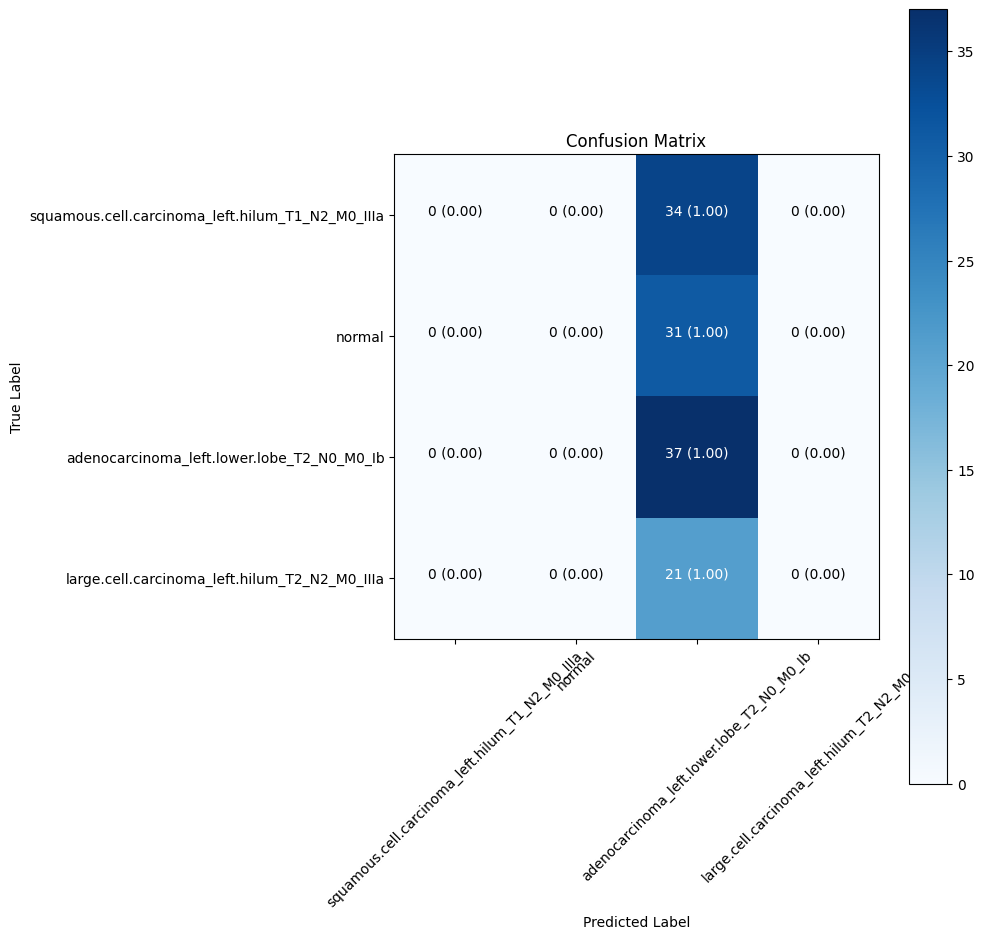

In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predictions = googlenet_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)


cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)


label_to_int_inv = {v: k for k, v in label_to_int.items()}
classes = [label_to_int_inv[i] for i in range(num_classes)]


plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + " (" + format(cm_normalized[i, j], '.2f') + ")",
             horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 30.08%


In [13]:
from sklearn.metrics import classification_report
report = classification_report(np.argmax(test_labels, axis=1), predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        31
           2       0.30      1.00      0.46        37
           3       0.00      0.00      0.00        21

    accuracy                           0.30       123
   macro avg       0.08      0.25      0.12       123
weighted avg       0.09      0.30      0.14       123



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Precision: 0.09
Recall: 0.30
F1-Score: 0.14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


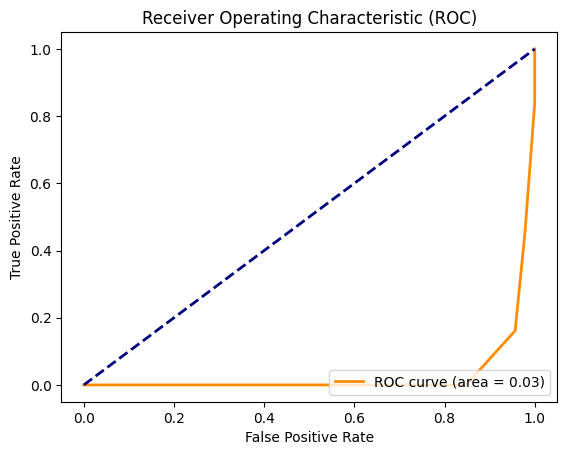

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_labels[:, 1], predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

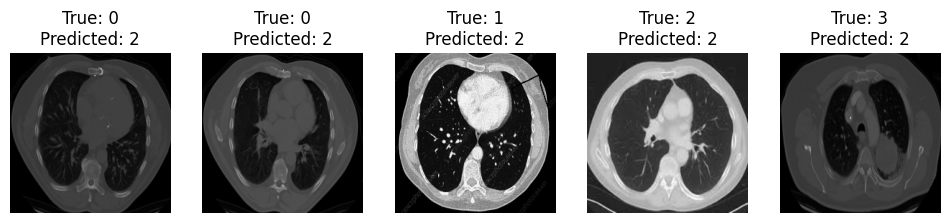

In [16]:
import random
random_indices = random.sample(range(len(test_data)), 5)
sample_images = test_data[random_indices]
sample_true_labels = np.argmax(test_labels[random_indices], axis=1)
sample_predicted_labels = predicted_labels[random_indices]
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}")
    plt.axis('off')
plt.show()

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/10
16/16 [==============================] - 13s 399ms/step - loss: 6.1035 - accuracy: 0.3918 - val_loss: 0.7943 - val_accuracy: 0.6179
Epoch 2/10
16/16 [==============================] - 2s 128ms/step - loss: 0.5759 - accuracy: 0.7592 - val_loss: 0.7462 - val_accuracy: 0.6667
Epoch 3/10
16/16 [==============================] - 2s 129ms/step - loss: 0.2056 - accuracy: 0.9327 - val_loss: 0.4660 - val_accuracy: 0.7886
Epoch 4/10
16/16 [==============================] - 2s 125ms/step - loss: 0.0883 - accuracy: 0.9816 - val_loss: 0.4601 - val_accuracy: 0.8211
Epoch 5/10
16/16 [==============================] - 2s 124ms/step - loss: 0.0661 - accuracy: 0.9857 - val_loss: 0.3802 - val_accuracy: 0.8374
Epoch 6/10
16/16 [==============================] - 2s 125ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.3577 - val_accuracy: 0.8374
Epoch 7/10
16/16 [==============================] - 2s 124ms/step - loss: 0.0166 -

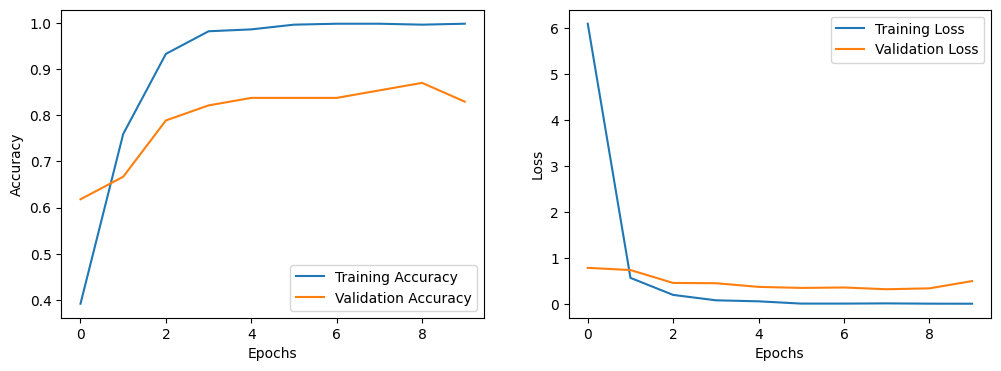

In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False

googlenet_model = Model(inputs=base_model.input, outputs=output_layer)

optimizer = Adam(learning_rate=0.0001)
googlenet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_save_path = "my_fine_tuned_googlenet_model.h5"
googlenet_model.save(model_save_path)

batch_size = 32
epochs = 10

history = googlenet_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

test_loss, test_accuracy = googlenet_model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

plot_history(history)

4/4 [==============================] - 1s 92ms/step


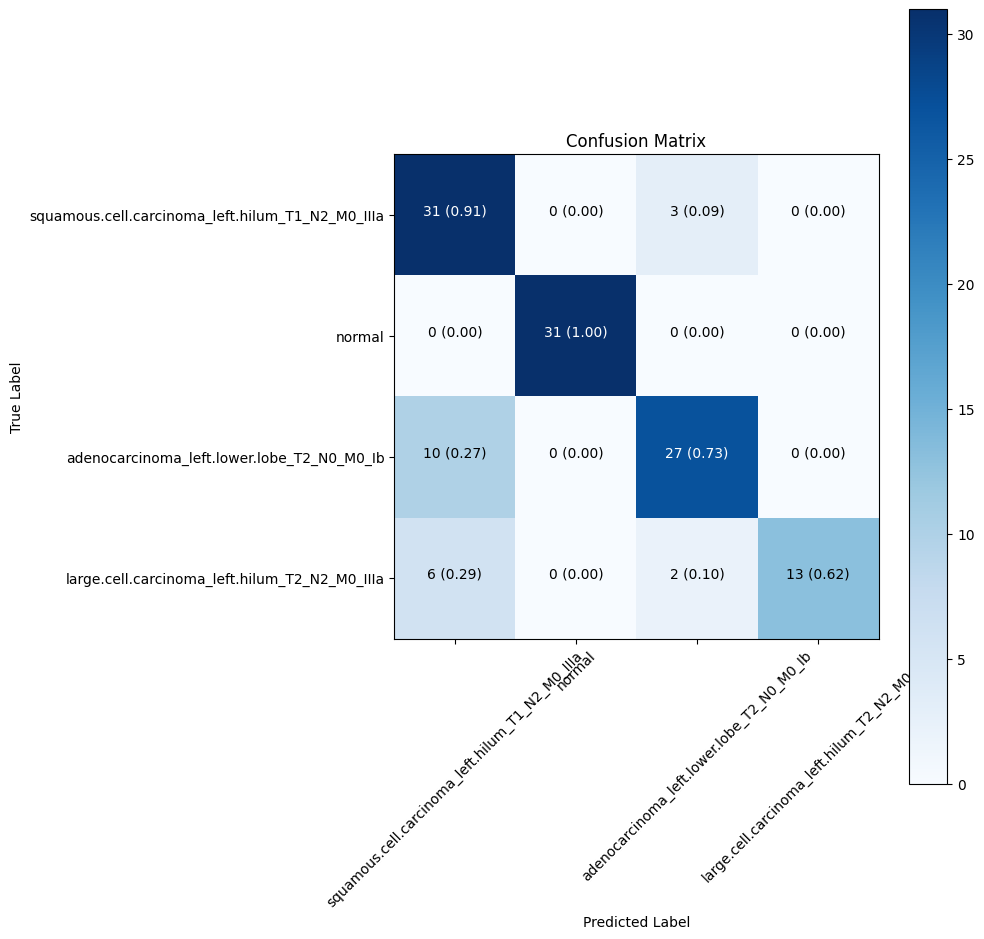

Accuracy: 82.93%


In [18]:

predictions = googlenet_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

label_to_int_inv = {v: k for k, v in label_to_int.items()}
classes = [label_to_int_inv[i] for i in range(num_classes)]

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + " (" + format(cm_normalized[i, j], '.2f') + ")",
             horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))

In [19]:
googlenet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_57[0][0]']              
 alization)                     )                                                           

Please upload a CT scan image:


Saving 000066 - Copy.png to 000066 - Copy.png
1/1 [==============================] - 2s 2s/step
The input image has lung cancer.
Class of lung cancer: squamous.cell.carcinoma


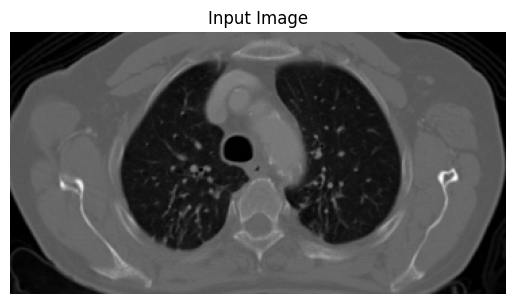

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model_path = "/content/my_fine_tuned_googlenet_model.h5"
fine_tuned_model = load_model(model_path)


def preprocess_input_image(image_path, input_shape):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, input_shape)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image


def get_predicted_label(predictions, label_to_int):
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = list(label_to_int.keys())[list(label_to_int.values()).index(predicted_class)]
    return predicted_label


label_to_int = {
     "adenocarcinoma": 0,
    "large Cell carcinoma": 1,
    "normal": 2,
     "squamous.cell.carcinoma": 3
}


print("Please upload a CT scan image:")
uploaded_files = files.upload()


input_image_path = list(uploaded_files.keys())[0]


input_shape = (224, 224)
input_image = preprocess_input_image(input_image_path, input_shape)

predictions = fine_tuned_model.predict(input_image)

predicted_label = get_predicted_label(predictions, label_to_int)

lung_cancer_classes = ["squamous.cell.carcinoma", "large Cell carcinoma", "adenocarcinoma"]
if predicted_label in lung_cancer_classes:
    print("The input image has lung cancer.")
    print("Class of lung cancer:", predicted_label)
else:
    print("The input image does not have lung cancer. It is classified as:", predicted_label)

# Display the input image
plt.imshow(cv2.imread(input_image_path))
plt.title("Input Image")
plt.axis('off')
plt.show()
